# Importação de bibliotecas

In [1]:
import numpy as np
from geneticalgorithm_modified import geneticalgorithm as ga
from enum import Enum
import pandas as pd
import timeit
import warnings
import math
warnings.filterwarnings('ignore')

# Declaração de funções e classes

In [2]:
class AvaliacaoAlgoritmo:
    """
    Classe para registrar o resultado das execuções de um algoritmo
    """

    def __init__(self,quantidade_repeticoes,lista_parametros):
        self.quantidade_repeticoes = quantidade_repeticoes
        self.lista_parametros = lista_parametros
    def retorna_resultados(self,funcao,nome_algoritmo):
        data=[]
        for parametro in self.lista_parametros:
            for i in range(self.quantidade_repeticoes):
                starttime = timeit.default_timer()
                custo = funcao(*parametro)
                interval =  timeit.default_timer() - starttime
                data.append([nome_algoritmo,parametro,custo,interval])
        retorno = pd.DataFrame(data=data,columns=['algoritmo','parametro','custo','tempo'])
        return retorno
def gera_parametro(complexidade):
    """
    Função para gerar parâmetros de acordo com a complexidade ie quantidade de caracteres
    A desenvolver
    :param complexidade:
    :return:
    """
    return ('abcdef','acdef')
class Operacoes(Enum):
    NOP = 0
    SUBSTITUICAO = 1
    ADICAO = 2
    REMOCAO = 3

class ContaOperacoes:
    """
    Classe utilizada para a contagem de operações (adição, remoção, substituição e
    manutenção de caractere) para transformar uma string em outra
    """
    def __init__(self,str1,str2):
        self.str1=str1
        self.str2=str2
        self.add_=0
        self.sub_=0
        self.delete_=0
        self.nop_=0
        self.error = False

    def add(self):
        self.add_+=1
        return 1
    def delete(self):
        self.delete_+=1
        return 1
    def nop(self):
        self.nop_+=1
        try:
            if self.str1[self.sub_+self.delete_+self.nop_-1] == self.str2[self.sub_+self.add_+self.nop_-1]:
                return 0
            self.error = True
            return 3
        except IndexError:
            return 2
    def sub(self):
        self.sub_+=1
        return 1
    def recupera_erros(self):
        return abs(len(self.str2) - (len(self.str1) - self.delete_ + self.add_))*3

class GeneticDistance:
    """
    Classe com os métodos para o cálculo da distância entre duas strings a
    partir do resultado dos algoritmos genéticos, que retornam as operações necessárias
    para a alteração da string 1 em 2
    """

    def __init__(self,stringa,stringb):
        self.stringa = stringa
        self.stringb = stringb
        self.na = len(self.stringa)
        self.nb = len(self.stringb)
        self.n_tamanho = max(self.na,self.nb)


    def get_tamanho(self):
        return self.n_tamanho

    def recupera_caractere_palavra_a(self,n):
        if n<=self.na-1:
            return self.stringa[n]
        else:
            return self.stringa[self.na-1]

    def recupera_caractere_palavra_b(self,m):
        if m<=self.nb-1:
            return self.stringb[m]
        else:
            return self.stringb[self.nb-1]

    def custo_otimizado2(self,parametros):
        contador = ContaOperacoes(self.stringa,self.stringb)
        custo = [contador.add() if i == Operacoes.ADICAO.value else contador.delete() if i==Operacoes.REMOCAO.value else contador.sub() if i == Operacoes.SUBSTITUICAO.value else contador.nop()  for i in parametros]
        custo =np.sum(custo)
        custo += contador.recupera_erros()
        return custo

    def custo_otimizado(self,parametros):
        custo = 0
        adicoes = np.sum([1 if i == Operacoes.ADICAO.value else 0 for i in parametros])
        remocoes = np.sum([1 if i == Operacoes.REMOCAO.value else 0 for i in parametros])
        substituicoes = np.sum([1 if i == Operacoes.SUBSTITUICAO.value else 0 for i in parametros])
        operacoes_nop = [k for k,v in enumerate(parametros) if v == Operacoes.NOP.value]

        ultima_operacao_nop=0
        adicoes_anteriores=0
        remocoes_anteriores=0
        substuicoes_anteriores=0

        for i in operacoes_nop:
            adicoes_anteriores += int(np.sum([1 if parametros[i2] == Operacoes.ADICAO.value else 0 for i2 in range(ultima_operacao_nop,i)]))
            remocoes_anteriores +=int(np.sum([1 if parametros[i2] == Operacoes.REMOCAO.value else 0 for i2 in range(ultima_operacao_nop,i)]))
            substuicoes_anteriores += int(np.sum([1 if (parametros[i2] == Operacoes.REMOCAO.value) or (parametros[i2] == Operacoes.NOP.value) \
                                                     else 0 for i2 in range(ultima_operacao_nop,i)]))
            ultima_operacao_nop=i
            try:
                if self.stringa[substuicoes_anteriores+remocoes_anteriores] != self.stringb[substuicoes_anteriores+adicoes_anteriores]:
                    custo+=4# penalizar no caso de operacoes que indicam substituições e os caracteres são diferentes
            except IndexError:
                custo+=4
        if self.na-remocoes+adicoes != self.nb:
            custo+=(remocoes+adicoes)*2#penalizar no caso de operações que não resultariam na correção adequada
        custo+=adicoes+remocoes+substituicoes
        return custo

    def custo(self,parametros):
        custo = 0
        n,m = (0,0)
        for i in range(len(parametros)):
            if parametros[i] == Operacoes.NOP.value:
                if self.recupera_caractere_palavra_a(n) == self.recupera_caractere_palavra_b(m):
                    n+=1
                    m+=1
                else:
                    custo=custo+3 # penalizar situacoes em que caracteres não são iguais e não foi indicada
                    #uma operação de alteração
            elif parametros[i] == Operacoes.SUBSTITUICAO.value:
                n+=1
                m+=1
                custo+=1
            elif parametros[i] == Operacoes.ADICAO.value:
                m+=1
                custo+=1
            elif parametros[i] == Operacoes.REMOCAO.value:
                n+=1
                custo+=1
        if (n != self.na) and (n != self.na+1):
            return custo+4
        elif m != self.nb:
            return custo+4
        return custo

def distancia_genetic(a,b):
    """
    Função proxy para a utilização de algoritmos genéticos para o cálculo do custo
    para a transformação de uma string em outra
    :param a: palavra 1
    :param b: palavra 2
    :return: custo de transformação da string 1 em string 2 segundo o algoritmo genético
    """
    f = GeneticDistance(a,b)
    total_populacao=4**(max(len(a),len(b)))
    populacao_avaliada = max(total_populacao*0.001,10)
    interacoes = max(populacao_avaliada,30)

    varbound =  np.array([[0,3]]*f.n_tamanho)
    algorithm_param = {'max_num_iteration': interacoes,\
                       'population_size':populacao_avaliada,\
                       'mutation_probability':0.1,\
                       'elit_ratio': 0.01,\
                       'crossover_probability': 0.9,\
                       'parents_portion': 0.3,\
                       'crossover_type':'uniform',\
                       'max_iteration_without_improv':20}
    model = ga(function=f.custo_otimizado2,dimension=f.n_tamanho,variable_type='int',variable_boundaries=varbound\
               ,convergence_curve=False,progress_bar=False,\
               algorithm_parameters=algorithm_param)
    model.run()
    return model.best_function




def LevenshteinD(word1, word2):
    #"""Dynamic programming solution"""
    m = len(word1)
    n = len(word2)
    table = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        table[i][0] = i
    for j in range(n + 1):
        table[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if word1[i - 1] == word2[j - 1]:
                table[i][j] = table[i - 1][j - 1]
            else:
                table[i][j] = 1 + min(table[i - 1][j], table[i][j - 1], table[i - 1][j - 1])

    return table[-1][-1]


In [3]:
"""

"""
str1 ='Amilton'
str2 = 'Amilton2'


# Descrição do problema


# Abordagem de algoritmos genéticos (Metaheurística)

In [6]:
avaliacao_genetico = AvaliacaoAlgoritmo(20,[(str1,str2)])
df = avaliacao_genetico.retorna_resultados(distancia_genetic,'Genéticos')

df.tail()

,algoritmo,parametro,custo,tempo
15,Genéticos,"(Amilton, Amilton2)",1.0,3.411886
16,Genéticos,"(Amilton, Amilton2)",1.0,3.514459
17,Genéticos,"(Amilton, Amilton2)",1.0,4.732972
18,Genéticos,"(Amilton, Amilton2)",1.0,3.991074
19,Genéticos,"(Amilton, Amilton2)",1.0,4.292666


<AxesSubplot:>

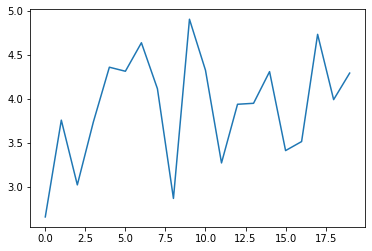

In [8]:
df['tempo'].plot()

# Abordagem programação dinâmica

In [9]:
avaliacao_levenstein = AvaliacaoAlgoritmo(20,[(str1,str2)])
df2 = avaliacao_levenstein.retorna_resultados(LevenshteinD,'levenstein')

<AxesSubplot:>

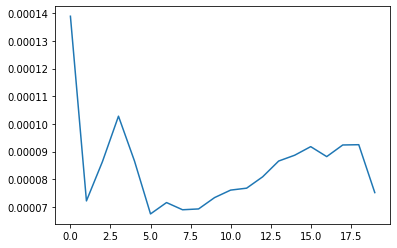

In [11]:
df2['tempo'].plot()
